# О проекте "Поступление в театральный вуз"

## Цель исследования
Анализ обсуждений в Telegram-чате абитуриентов театральных вузов для выявления ключевых тем, частоты упоминаний вузов, динамики активности и влияния факторов коррупции и блата на процесс поступления.

## Задачи исследования

*   Определить популярные театральные вузы по частоте упоминаний.
*   Выявить основные темы обсуждений (экзамены, мастерские, конкурс и т. д.).
*   Проанализировать сезонность обсуждений (когда активность максимальна: перед экзаменами, во время приёмной кампании и т. д.).
*   Изучить временные паттерны сообщений (в какое время суток чаще обсуждают поступление).
*   Оценить обсуждения коррупции и блата (какие формулировки используются, в каких вузах чаще упоминаются подобные темы).
*   Идентифицировать ключевых участников и их влияние на беседу.

## Ход работы

### Блок 0. Считывание данных и предварительная обработка.

Считаем json-файлы трёх чатов в телеграме на тему поступления в театральный вуз

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import re
import seaborn as sns
import folium
from geopy.geocoders import Nominatim
import time
import nltk
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords

In [74]:
f = open('result_1.json', 'r', encoding='utf-8')
data_1 = json.load(f)
f.close()

# Словарь для датафрейма
d_1 = {'id':[],'type':[], 'text':[], 'action':[], 'date':[], 'edited':[],'from':[]}

for message in data_1['messages']:

    if message['type'] == 'message':
        d_1['id'].append(message['id'])
        d_1['type'].append(message['type'])
        d_1['action'].append('')
        d_1['date'].append(message['date'])
        d_1['from'].append(message['from'])
        if 'text' in message:
            d_1['text'].append(message['text'])
            if 'edited' in message:
                d_1['edited'].append(message['edited'])
            else:
                d_1['edited'].append('')
        else:
            d_1['text'].append('')
    else:
      d_1['id'].append(message['id'])
      d_1['type'].append(message['type'])
      d_1['action'].append(message['action'])
      d_1['date'].append(message['date'])
      d_1['from'].append(message['actor'])
      d_1['edited'].append('')
      d_1['text'].append('')

# Создание датафрейма из словаря
df_1 = pd.DataFrame(d_1)

Обработаем датафрейм №1

In [75]:
# Удалим ссылки из df и преобразуем list в str
for idx in df_1.index:
    if type(df_1.loc[idx, 'text']) == list:
        new_string = ''
        for elem in df_1.loc[idx, 'text']:
            if type(elem) == str:
                new_string += elem
        df_1.loc[idx, 'text'] = new_string

#Сделаем новые колонки по дате
df_1['date'] = pd.to_datetime(df_1['date'], format='%Y-%m-%dT%H:%M:%S')
df_1['year'] = df_1['date'].dt.year
df_1['month'] = df_1['date'].dt.month
df_1['day'] = df_1['date'].dt.day_name()
df_1['hour'] = df_1['date'].dt.hour


#Унифицируем столбцы
df_1['text'] = df_1['text'].replace("", np.nan)
df_1['action'] = df_1['action'].replace("", np.nan)

#Активность аккаунта пользователя (сколько сообщений отправил)
from_counts = df_1['from'].value_counts().to_dict()
df_1['sender_frequency'] = df_1['from'].map(from_counts)

#Длина текста
df_1["message_length"] = df_1["text"].astype(str).apply(len)

In [76]:
df_1

,id,type,text,action,date,edited,from,year,month,day,hour,sender_frequency,message_length
0,98763,message,буду очень благодарна если поделишься материал...,NaN,2024-03-22 02:18:39,,Kris,2024,3,Friday,2,2.0,51
1,98764,message,можно тоже фото 🥺,NaN,2024-03-22 02:51:20,,kklizzma,2024,3,Friday,2,28.0,17
2,98765,message,"Здравствуйте, можно фото в лс, благодарю! 🥺",NaN,2024-03-22 11:15:10,,Вероника,2024,3,Friday,11,28.0,43
3,98766,message,NaN,NaN,2024-03-22 11:15:10,,Вероника,2024,3,Friday,11,28.0,3
4,98767,message,Можно в лс 🙏🏼,NaN,2024-03-22 12:09:57,,Artyom Pleshkov,2024,3,Friday,12,13.0,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28439,132144,message,"Замечательно, откисаю вот дома. Ты как, дорогой?",NaN,2025-03-21 00:16:28,,Ярослав Мудригель,2025,3,Friday,0,170.0,48
28440,132145,message,дома это в саратове?,NaN,2025-03-21 00:16:38,,Ваня.,2025,3,Friday,0,1023.0,20
28441,132146,message,"нет, дома это дома в Питере",NaN,2025-03-21 00:17:01,,Ярослав Мудригель,2025,3,Friday,0,170.0,27
28442,132147,message,NaN,NaN,2025-03-21 06:46:50,,Arakelyan Van | Дядюшка Арчибальд🚜🩸,2025,3,Friday,6,3.0,3


Повторим с двумя другими чатами

In [77]:
# Второй чат

f = open('result_2.json', 'r', encoding='utf-8')
data_2 = json.load(f)
f.close()


# Словарь для датафрейма
d_2 = {'id':[],'type':[], 'text':[], 'action':[], 'date':[], 'edited':[],'from':[]}

for message in data_2['messages']:

    if message['type'] == 'message':
        d_2['id'].append(message['id'])
        d_2['type'].append(message['type'])
        d_2['action'].append('')
        d_2['date'].append(message['date'])
        d_2['from'].append(message['from'])
        if 'text' in message:
            d_2['text'].append(message['text'])
            if 'edited' in message:
                d_2['edited'].append(message['edited'])
            else:
                d_2['edited'].append('')
        else:
            d_2['text'].append('')
    else:
      d_2['id'].append(message['id'])
      d_2['type'].append(message['type'])
      d_2['action'].append(message['action'])
      d_2['date'].append(message['date'])
      d_2['from'].append(message['actor'])
      d_2['edited'].append('')
      d_2['text'].append('')

# Создание датафрейма из словаря
df_2 = pd.DataFrame(d_2)

# Удалим ссылки из df и преобразуем list в str
for idx in df_2.index:
    if type(df_2.loc[idx, 'text']) == list:
        new_string = ''
        for elem in df_2.loc[idx, 'text']:
            if type(elem) == str:
                new_string += elem
        df_2.loc[idx, 'text'] = new_string

#Сделаем новые колонки по дате
df_2['date'] = pd.to_datetime(df_2['date'], format='%Y-%m-%dT%H:%M:%S')
df_2['year'] = df_2['date'].dt.year
df_2['month'] = df_2['date'].dt.month
df_2['day'] = df_2['date'].dt.day_name()
df_2['hour'] = df_2['date'].dt.hour

#Унифицируем столбцы
df_2['text'] = df_2['text'].replace("", np.nan)
df_2['action'] = df_2['action'].replace("", np.nan)

#Активность аккаунта пользователя (сколько сообщений отправил)
from_counts = df_2['from'].value_counts().to_dict()
df_2['sender_frequency'] = df_2['from'].map(from_counts)

#Длина текста
df_2["message_length"] = df_2["text"].astype(str).apply(len)

df_2

,id,type,text,action,date,edited,from,year,month,day,hour,sender_frequency,message_length
0,9799,service,NaN,invite_members,2024-03-25 19:57:09,,Егор Буйнов,2024,3,Monday,19,1.0,3
1,9800,service,NaN,invite_members,2024-03-28 08:18:27,,BuYana,2024,3,Thursday,8,1.0,3
2,9801,message,"Добрый всем вечер)\nХотела узнать, в Щуку виде...",NaN,2024-03-29 22:52:05,,Jededaddy,2024,3,Friday,22,7.0,172
3,9802,message,До июня вроде можно,NaN,2024-03-29 22:52:41,2024-03-29T22:53:42,🇷🇺❤️,2024,3,Friday,22,1.0,19
4,9803,message,можно на протяжении всего апреля-мая но по ощу...,NaN,2024-03-29 22:52:51,2024-03-29T22:53:41,лина 🧚‍♂️,2024,3,Friday,22,1.0,72
...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,10136,service,NaN,invite_members,2025-01-11 20:10:53,,BELA~ RUS,2025,1,Saturday,20,1.0,3
324,10137,service,NaN,invite_members,2025-01-31 23:08:53,,Tattooing_as makeouthere,2025,1,Friday,23,1.0,3
325,10138,service,NaN,invite_members,2025-02-04 11:00:26,,ви,2025,2,Tuesday,11,1.0,3
326,10139,service,NaN,invite_members,2025-02-08 15:53:05,,Ира Крючкова,2025,2,Saturday,15,1.0,3


In [78]:
# Третий чат

f = open('result_3.json', 'r', encoding='utf-8')
data_3 = json.load(f)
f.close()


# Словарь для датафрейма
d_3 = {'id':[],'type':[], 'text':[], 'action':[], 'date':[], 'edited':[],'from':[]}

for message in data_3['messages']:

    if message['type'] == 'message':
        d_3['id'].append(message['id'])
        d_3['type'].append(message['type'])
        d_3['action'].append('')
        d_3['date'].append(message['date'])
        d_3['from'].append(message['from'])
        if 'text' in message:
            d_3['text'].append(message['text'])
            if 'edited' in message:
                d_3['edited'].append(message['edited'])
            else:
                d_3['edited'].append('')
        else:
            d_3['text'].append('')
    else:
      d_3['id'].append(message['id'])
      d_3['type'].append(message['type'])
      d_3['action'].append(message['action'])
      d_3['date'].append(message['date'])
      d_3['from'].append(message['actor'])
      d_3['edited'].append('')
      d_3['text'].append('')

# Создание датафрейма из словаря
df_3 = pd.DataFrame(d_3)

# Удалим ссылки из df и преобразуем list в str
for idx in df_3.index:
    if type(df_3.loc[idx, 'text']) == list:
        new_string = ''
        for elem in df_3.loc[idx, 'text']:
            if type(elem) == str:
                new_string += elem
        df_3.loc[idx, 'text'] = new_string

#Сделаем новые колонки по дате
df_3['date'] = pd.to_datetime(df_3['date'], format='%Y-%m-%dT%H:%M:%S')
df_3['year'] = df_3['date'].dt.year
df_3['month'] = df_3['date'].dt.month
df_3['day'] = df_3['date'].dt.day_name()
df_3['hour'] = df_3['date'].dt.hour

#Закодируем, отредактировано ли сообщение или нет
pd.set_option('mode.use_inf_as_na', True)
df_3['edited'] = df_3['edited'].replace("", np.nan)
df_3['is_edited'] = df_3['edited'].notna()

#Унифицируем столбцы
df_3['text'] = df_3['text'].replace("", np.nan)
df_3['action'] = df_3['action'].replace("", np.nan)

#Активность аккаунта пользователя (сколько сообщений отправил)
from_counts = df_3['from'].value_counts().to_dict()
df_3['sender_frequency'] = df_3['from'].map(from_counts)

#Длина текста
df_3["message_length"] = df_3["text"].astype(str).apply(len)

df_3

<ipython-input-78-7367e04e622e>:56: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.set_option('mode.use_inf_as_na', True)


,id,type,text,action,date,edited,from,year,month,day,hour,is_edited,sender_frequency,message_length
0,1,service,NaN,create_channel,2023-01-30 20:02:08,NaN,На страже канала Мити Чеблакова,2023,1,Monday,20,False,86.0,3
1,2,service,NaN,edit_group_photo,2023-01-30 20:12:53,NaN,На страже канала Мити Чеблакова,2023,1,Monday,20,False,86.0,3
2,3,message,Иууу 🔥\n\nОткрыли чат!\nДавайте общаться насче...,NaN,2023-01-30 20:14:36,2023-02-01T12:18:53,ОТКРЫТЫЙ УРОК | Мастерская поступления,2023,1,Monday,20,True,48.0,144
3,4,service,NaN,join_group_by_link,2023-01-30 20:14:41,NaN,Anna,2023,1,Monday,20,False,11.0,3
4,5,service,NaN,join_group_by_link,2023-01-30 20:14:45,NaN,Ксюша,2023,1,Monday,20,False,3.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2546,2680,message,По поводу прослушиваний напишите Мите,NaN,2025-03-20 21:44:48,NaN,На страже канала Мити Чеблакова,2025,3,Thursday,21,False,86.0,38
2547,2681,message,Спасибо за эфир🙏🏻\nОн был очень важен и ценен🙏🏻,NaN,2025-03-20 21:45:08,NaN,Лада Щибрик,2025,3,Thursday,21,False,8.0,46
2548,2682,message,да!!\nспасибо большое 🙏,NaN,2025-03-20 21:45:19,NaN,алина,2025,3,Thursday,21,False,27.0,22
2549,2683,message,как всегда кайф,NaN,2025-03-20 21:45:28,NaN,ᴠɪᴄᴛᴏʀɪ,2025,3,Thursday,21,False,27.0,15


Объединим три датафрейма в один

In [79]:
df = pd.concat([df_1, df_2, df_2], ignore_index=True)
df

,id,type,text,action,date,edited,from,year,month,day,hour,sender_frequency,message_length
0,98763,message,буду очень благодарна если поделишься материал...,NaN,2024-03-22 02:18:39,,Kris,2024,3,Friday,2,2.0,51
1,98764,message,можно тоже фото 🥺,NaN,2024-03-22 02:51:20,,kklizzma,2024,3,Friday,2,28.0,17
2,98765,message,"Здравствуйте, можно фото в лс, благодарю! 🥺",NaN,2024-03-22 11:15:10,,Вероника,2024,3,Friday,11,28.0,43
3,98766,message,NaN,NaN,2024-03-22 11:15:10,,Вероника,2024,3,Friday,11,28.0,3
4,98767,message,Можно в лс 🙏🏼,NaN,2024-03-22 12:09:57,,Artyom Pleshkov,2024,3,Friday,12,13.0,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29095,10136,service,NaN,invite_members,2025-01-11 20:10:53,,BELA~ RUS,2025,1,Saturday,20,1.0,3
29096,10137,service,NaN,invite_members,2025-01-31 23:08:53,,Tattooing_as makeouthere,2025,1,Friday,23,1.0,3
29097,10138,service,NaN,invite_members,2025-02-04 11:00:26,,ви,2025,2,Tuesday,11,1.0,3
29098,10139,service,NaN,invite_members,2025-02-08 15:53:05,,Ира Крючкова,2025,2,Saturday,15,1.0,3


Сохраним в формате csv

In [80]:
df.to_csv("theatre_data.csv", index=False, encoding="utf-8")

Приступим к обработке данных

### Блок 1. Анализ даты и времени

Гипотеза: активность в чатах возрастает соответственно календарю поступления (наиболее активные месяцы - с апреля по июль)

 Среднее число сообщений в месяц: 2425.00, медианное: 823.5
 Среднее число сообщений в день: 4157.14, медианное: 3538.0
 Среднее число сообщений в час: 1212.50, медианное: 1217.0


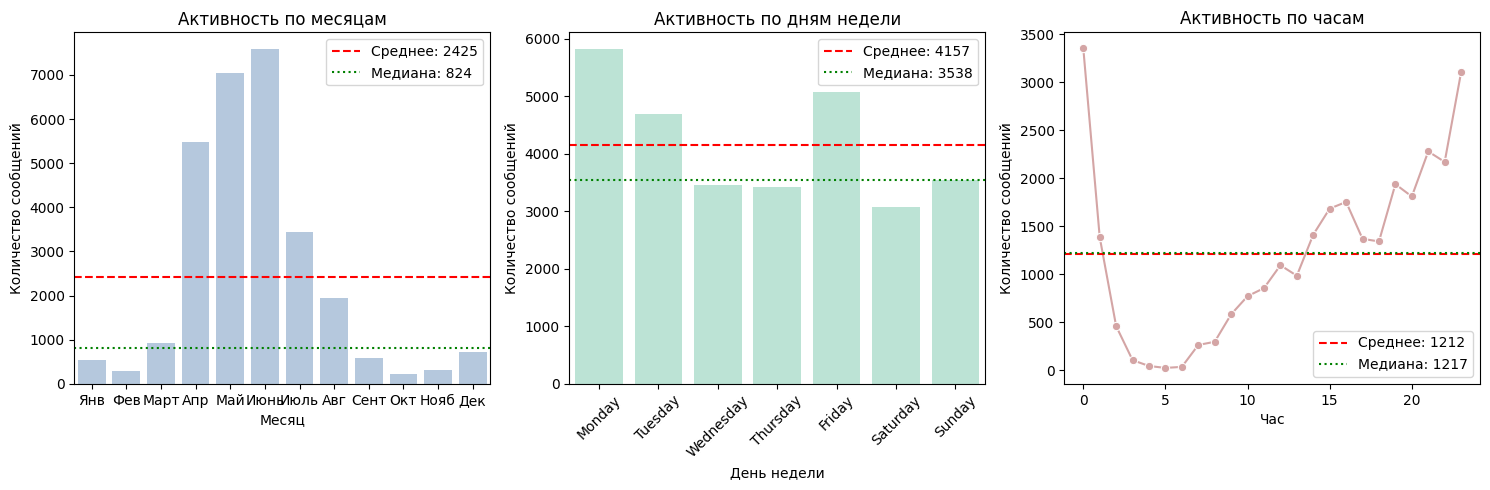

In [81]:
# Группируем данные по месяцам
monthly_activity = df.groupby('month')['id'].count().reset_index()
monthly_activity.rename(columns={'id': 'message_count'}, inplace=True)

# Вычисляем среднее и медианное количество сообщений в месяц
mean_monthly = monthly_activity["message_count"].mean()
median_monthly = monthly_activity["message_count"].median()

# Группируем данные по дням недели
weekly_activity = df.groupby('day')['id'].count().reset_index()
weekly_activity.rename(columns={'id': 'message_count'}, inplace=True)

# Упорядочим дни недели (pandas считает их строками)
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_activity['day'] = pd.Categorical(weekly_activity['day'], categories=days_order, ordered=True)
weekly_activity = weekly_activity.sort_values('day')

# Вычисляем среднее и медианное количество сообщений в день
mean_weekly = weekly_activity["message_count"].mean()
median_weekly = weekly_activity["message_count"].median()

# Группируем данные по часам
hourly_activity = df.groupby('hour')['id'].count().reset_index()
hourly_activity.rename(columns={'id': 'message_count'}, inplace=True)

# Вычисляем среднее и медианное количество сообщений в час
mean_hourly = hourly_activity["message_count"].mean()
median_hourly = hourly_activity["message_count"].median()

# Вывод средних и медианных значений
print(f" Среднее число сообщений в месяц: {mean_monthly:.2f}, медианное: {median_monthly}")
print(f" Среднее число сообщений в день: {mean_weekly:.2f}, медианное: {median_weekly}")
print(f" Среднее число сообщений в час: {mean_hourly:.2f}, медианное: {median_hourly}")

# Строим графики
plt.figure(figsize=(15, 5))

# Гистограмма активности по месяцам
plt.subplot(1, 3, 1)
sns.barplot(data=monthly_activity, x='month', y='message_count', color='#AFC8E3')
plt.axhline(mean_monthly, color='red', linestyle='dashed', label=f'Среднее: {mean_monthly:.0f}')
plt.axhline(median_monthly, color='green', linestyle='dotted', label=f'Медиана: {median_monthly:.0f}')
plt.xlabel("Месяц")
plt.ylabel("Количество сообщений")
plt.title("Активность по месяцам")
plt.xticks(range(12), ['Янв', 'Фев', 'Март', 'Апр', 'Май', 'Июнь', 'Июль', 'Авг', 'Сент', 'Окт', 'Нояб', 'Дек'])
plt.legend()

# Гистограмма активности по дням недели
plt.subplot(1, 3, 2)
sns.barplot(data=weekly_activity, x='day', y='message_count', color='#B5EAD7')
plt.axhline(mean_weekly, color='red', linestyle='dashed', label=f'Среднее: {mean_weekly:.0f}')
plt.axhline(median_weekly, color='green', linestyle='dotted', label=f'Медиана: {median_weekly:.0f}')
plt.xlabel("День недели")
plt.ylabel("Количество сообщений")
plt.title("Активность по дням недели")
plt.xticks(rotation=45)
plt.legend()

# Линейный график активности по часам
plt.subplot(1, 3, 3)
sns.lineplot(data=hourly_activity, x='hour', y='message_count', marker="o", color='#D4A5A5')
plt.axhline(mean_hourly, color='red', linestyle='dashed', label=f'Среднее: {mean_hourly:.0f}')
plt.axhline(median_hourly, color='green', linestyle='dotted', label=f'Медиана: {median_hourly:.0f}')
plt.xlabel("Час")
plt.ylabel("Количество сообщений")
plt.title("Активность по часам")
plt.legend()

plt.tight_layout()
plt.show()


### Блок 2. Анализ и сегментация пользователей по активности

 Среднее количество сообщений на пользователя: 36.75
 Медианное количество сообщений на пользователя: 5.0
                      user  message_count
0   лизавета александровна           1578
1      Nicole crazyyyyyyyy           1407
2         Валерий Гурьянов           1332
3           Steve Lopez 🇪🇺           1126
4              ксюшкинс 🎞️           1079
5                    Ваня.           1023
6                   Маруся            686
7          Dmitriy Zolotov            604
8                 ✨Tikhon✨            549
9           leo andraderas            533
10              𝑣𝑙𝑙𝑖𝑛𝑠𝑘𝑎𝑖𝑎            510
11                 pasha 🎀            495
12         Максим Сотников            492
13             Sonya Morse            429
14         Андрей Шувалов🪐            372
15              Anna Ulala            332
16                     Яся            328
17                       s            317
18            ксения греча            307
19                   Артем            305


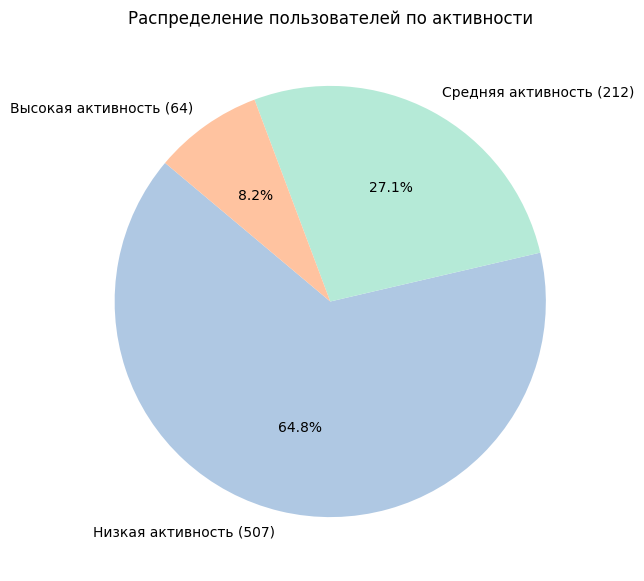

In [82]:
# Исключаем владельцев чата
excluded_names = ["💕ИЩУ ТЕБЯ ТЕАТРАЛЬНЫЙ", "ABITURIENT_beseda🎭", "На страже канала Мити Чеблакова"]
df_filtered = df[~df['from'].isin(excluded_names)]

# Подсчитываем количество сообщений у каждого пользователя
user_activity = df_filtered['from'].value_counts().reset_index()
user_activity.columns = ['user', 'message_count']

# Вычисляем среднее и медианное количество сообщений на пользователя
mean_messages = user_activity["message_count"].mean()
median_messages = user_activity["message_count"].median()

# Вывод статистики
print(f" Среднее количество сообщений на пользователя: {mean_messages:.2f}")
print(f" Медианное количество сообщений на пользователя: {median_messages}")

# Топ-20 активных пользователей
top_20_users = user_activity.head(20)
print(top_20_users)

# Разделяем пользователей на сегменты
def segment_users(count):
    if count >= 100:  # Активные пользователи
        return 'Высокая активность'
    elif count >= 10:  # Средняя активность
        return 'Средняя активность'
    else:  # Низкая активность
        return 'Низкая активность'

user_activity['segment'] = user_activity['message_count'].apply(segment_users)

# Считаем размер каждого сегмента
segment_counts = user_activity['segment'].value_counts()

# Строим круговую диаграмму
plt.figure(figsize=(7, 7))
colors = ['#AFC8E3', '#B5EAD7', '#FFC3A0']
plt.pie(segment_counts, labels=[f"{label} ({count})" for label, count in segment_counts.items()],
        autopct='%1.1f%%', colors=colors, startangle=140)
plt.title(f"Распределение пользователей по активности")
plt.show()


Проанализируем длину сообщений

In [83]:
mean_length = df["message_length"].mean()  # Средняя длина
median_length = df["message_length"].median()  # Медианная длина

print(f"Средняя длина сообщений: {mean_length:.2f} символов")
print(f"Медианная длина сообщений: {median_length:.2f} символов")

Средняя длина сообщений: 29.98 символов
Медианная длина сообщений: 18.00 символов


### Блок 3. Анализ частотных слов

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


            word  count
26       спасибо    439
706      сегодня    333
71          знаю    297
546        ребят    266
177       привет    256
721        нужно    212
208   пожалуйста    212
52        ребята    208
147          тур    198
1144      завтра    193
0           буду    187
404         могу    184
37          году    183
67         живой    174
311         пока    172
677         день    169
96          хочу    169
209      сколько    168
963        думаю    155
39          туда    149
121         прям    145
276        время    144
68         гитис    143
458       москве    143
770        ктото    140
278         хотя    137
48         такое    137
118         кого    136
257       почему    136
491        чтото    135


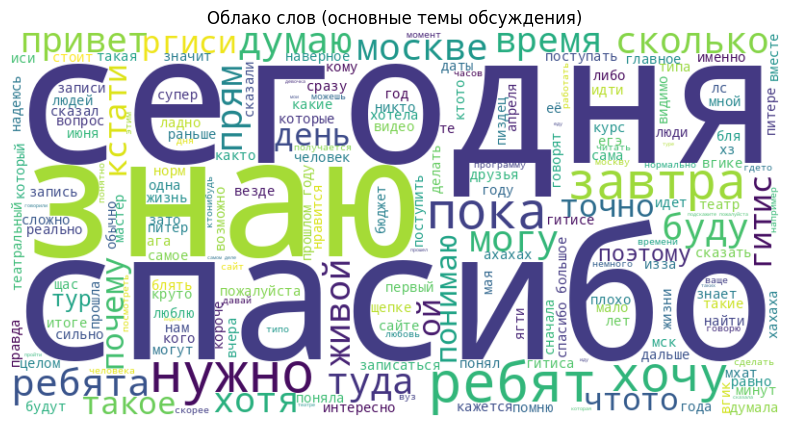

Файл с частотным анализом сохранён: word_freq.csv


In [86]:
# Загрузим русский список стоп-слов
nltk.download("stopwords")
stop_words = set(stopwords.words("russian"))

# Добавляем вручную некоторые лишние слова
stop_words.update(["это", "как", "очень", "просто", "все", "ещё", "там", "ну", "да", "вообще", "всем", "всё", "тебе", "вроде", "блин", "че"])

# Функция очистки текста
def clean_text(text):
    if isinstance(text, str):
        text = text.lower()  # Приводим к нижнему регистру
        text = re.sub(r"[^\w\s]", "", text)  # Убираем знаки препинания
        text = re.sub(r"\d+", "", text)  # Убираем цифры
        words = text.split()
        words = [word for word in words if word not in stop_words]  # Убираем стоп-слова
        return " ".join(words)
    return ""

# Применяем очистку ко всем сообщениям
df["clean_text"] = df["text"].apply(clean_text)

# Объединяем весь текст в один список слов
all_words = " ".join(df["clean_text"]).split()

# Подсчитываем частоту слов
word_freq = Counter(all_words)

# Преобразуем в DataFrame
word_freq_df = pd.DataFrame(word_freq.items(), columns=["word", "count"])
word_freq_df = word_freq_df.sort_values(by="count", ascending=False)

# Выведем топ-30 самых частых слов
print(word_freq_df.head(30))

# Построим облако слов для наглядности
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(all_words))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Облако слов (основные темы обсуждения)")
plt.show()

# Скачаем файл для кластеризации с помощью ИИ, я больше не могу
word_freq_df.to_csv("word_freq.csv", index=False, encoding="utf-8")
print("Файл с частотным анализом сохранён: word_freq.csv")

**Саммари частотного анализа сообщений о ГИТИСе**

**Дружеская атмосфера**

Высокая частотность слов "спасибо" (439), "пожалуйста" (212), "привет" (256), "ребята" (208).
Говорит о поддерживающей среде в обсуждениях про ГИТИС.

**Обсуждение сроков и дат**

Слова "сегодня" (333), "завтра" (193), "день" (169), "году" (183).
Вероятно, обсуждаются сроки поступления, даты экзаменов и туров.

**Поступление и экзамены**

Часто встречаются "тур" (198), "нужно" (212), "могу" (184), "сколько" (168).
Вероятно, люди спрашивают о процедуре поступления, конкурсных турах, проходных баллах.

**Переживания и ожидания**

"думаю" (155), "хочу" (169), "туда" (149), "буду" (187).

Отражает волнение абитуриентов, их желания и ожидания от поступления.


**Самые популярные вузы в обсуждениях**
1. ГИТИС — 143 упоминания
2. РГИСИ — 130 упоминаний
3. ВГИК — 114 упоминаний
4.  МХАТ — 77 упоминаний
5. Щепкинское училище ("Щепка") — 31 упоминание
6. Щукинское училище ("Щука") — 17 упоминаний

### Блок 4. Анализ сообщений с упоминанием самых популярных вузов (ГИТИС, ВГИК, РГИСИ)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


              word  count
3            живой     24
57           ребят     21
131        сегодня     18
95             тур     13
28          запись     13
166         завтра     12
91            мхат     11
53            вгик     11
105          щепка     10
244          театр      9
50            даты      8
290         привет      8
33            году      8
499         ребята      8
31            щука      7
119          ргиси      6
59      записаться      6
122  прослушивание      6
32         прошлом      6
133        очереди      6
6             знаю      6
448          сайте      6
278     пожалуйста      6
243            муз      5
311            нам      5
272            мая      5
249         записи      5
126           дату      5
183          новые      5
410     коручекову      5


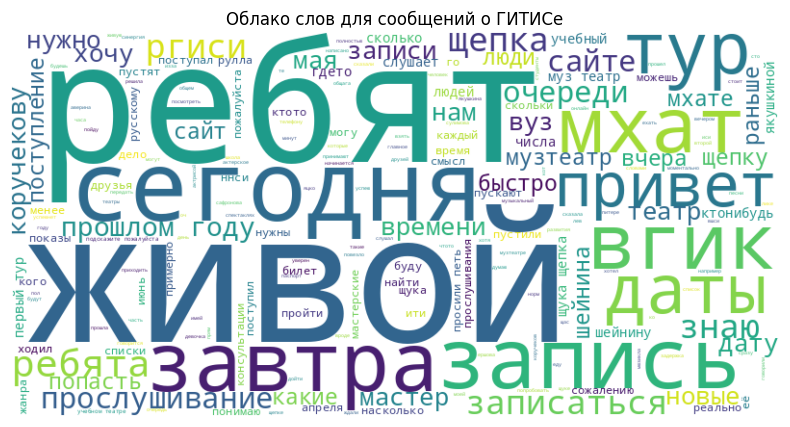

In [87]:
# ГИТИС!

# Загрузим русский список стоп-слов заново, чтобы убрать словоформы "гитис"
nltk.download("stopwords")
stop_words = set(stopwords.words("russian"))


# Фильтруем сообщения, содержащие "ГИТИС" (без учёта регистра) и создаём копию DataFrame
df_gitis = df[df["text"].str.contains("гитис", case=False, na=False)].copy()

# Добавляем вручную некоторые лишние слова
stop_words.update(["гитис", "гитиса", "гитисе", "это", "как", "очень", "просто", "все", "ещё", "там", "ну", "да", "вообще", "всем", "всё", "тебе"])

# Применяем очистку
df_gitis["clean_text"] = df_gitis["text"].apply(clean_text)

# Объединяем весь текст в один список слов
all_words_gitis = " ".join(df_gitis["clean_text"]).split()

# Подсчитываем частоту слов
word_freq_gitis = Counter(all_words_gitis)

# Преобразуем в DataFrame
word_freq_gitis_df = pd.DataFrame(word_freq_gitis.items(), columns=["word", "count"])
word_freq_gitis_df = word_freq_gitis_df.sort_values(by="count", ascending=False)

# Выведем топ-30 самых частых слов
print(word_freq_gitis_df.head(30))

# Построим облако слов
wordcloud_gitis = WordCloud(width=800, height=400, background_color="white").generate(" ".join(all_words_gitis))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_gitis, interpolation="bilinear")
plt.axis("off")
plt.title("Облако слов для сообщений о ГИТИСе")
plt.show()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


           word  count
36      сегодня     18
77       завтра     15
80         даты     12
82        гитис     11
34        ребят     11
92       запись     10
33       привет      8
183       живой      8
294         тур      7
194      ребята      7
47       апреля      7
51        ктото      7
46          ити      6
39   подскажите      6
4    записаться      5
53      сколько      5
83         щука      5
93          май      5
144        мхат      5
50         идти      5
145       щепка      5
42        нужна      4
319          те      4
31         пока      4
413       вгику      4
229         мая      4
25         могу      4
150  информация      4
226       нужно      4
151      записи      4


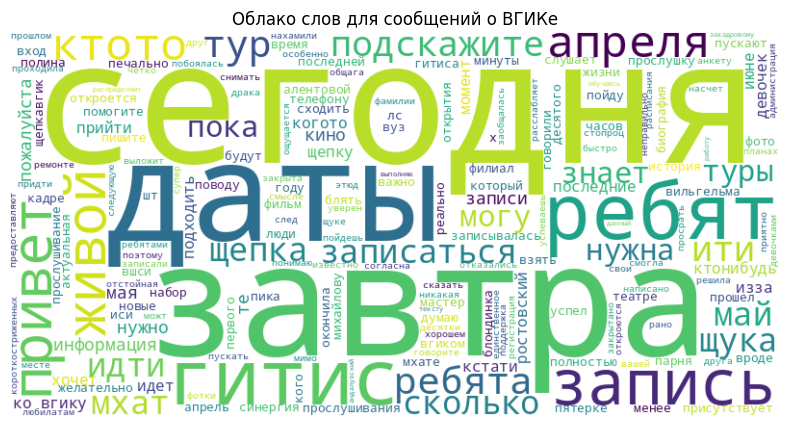

In [88]:
# ВГИК!

# Загрузим русский список стоп-слов заново, чтобы убрать словоформы "вгик"
nltk.download("stopwords")
stop_words = set(stopwords.words("russian"))

# Фильтруем сообщения, содержащие "ВГИК" (без учёта регистра) и создаём копию DataFrame
df_vgik = df[df['text'].str.contains("вгик", case=False, na=False)].copy()

# Добавляем вручную некоторые лишние слова
stop_words.update(["вгик", "вгике", "вгика", "это", "как", "очень", "просто", "все", "ещё", "там", "ну", "да", "вообще", "всем", "всё", "тебе"])

# Применяем очистку к сообщениям про ВГИК
df_vgik["clean_text"] = df_vgik["text"].apply(clean_text)

# Объединяем весь текст в один список слов
all_words_vgik = " ".join(df_vgik["clean_text"]).split()

# Подсчитываем частоту слов
word_freq_vgik = Counter(all_words_vgik)

# Преобразуем в DataFrame
word_freq_vgik_df = pd.DataFrame(word_freq_vgik.items(), columns=["word", "count"])
word_freq_vgik_df = word_freq_vgik_df.sort_values(by="count", ascending=False)

# Выведем топ-30 самых частых слов
print(word_freq_vgik_df.head(30))

# Построим облако слов
wordcloud_vgik = WordCloud(width=800, height=400, background_color="white").generate(" ".join(all_words_vgik))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_vgik, interpolation="bilinear")
plt.axis("off")
plt.title("Облако слов для сообщений о ВГИКе")
plt.show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


             word  count
65         ребята      9
2            году      8
12        сегодня      8
8            туда      7
50          живой      6
17           могу      6
306     документы      6
137         нужно      6
27      поступать      5
1         прошлом      5
173         курсе      5
6             тур      5
276        привет      5
39         запись      5
247         числа      4
171    подскажите      4
81            ити      4
91     пожалуйста      4
42          гитис      4
13      ктонибудь      4
267        питера      3
49        реально      3
248        первые      3
254         будут      3
255          июля      3
82            иси      3
221  консультации      3
348          курс      3
23         филиал      3
129     михайлова      3


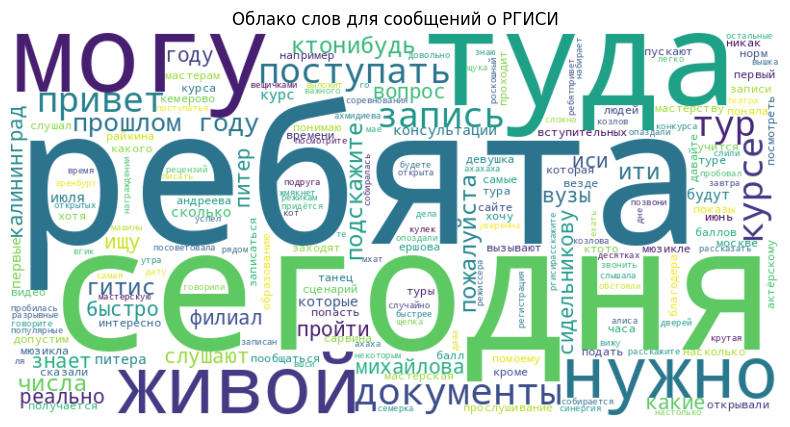

In [89]:
# РГИСИ!

# Загрузим русский список стоп-слов заново, чтобы убрать словоформы "ргиси"
nltk.download("stopwords")
stop_words = set(stopwords.words("russian"))

# Фильтруем сообщения, содержащие "РГИСИ" (без учёта регистра) и создаём копию DataFrame
df_rgisi = df[df['text'].str.contains("ргиси", case=False, na=False)].copy()

# Добавляем вручную некоторые лишние слова
stop_words.update(["ргиси", "ребят", "это", "как", "очень", "просто", "все", "ещё", "там", "ну", "да", "вообще", "всем", "всё", "тебе"])

# Применяем очистку к сообщениям про РГИСИ
df_rgisi["clean_text"] = df_rgisi["text"].apply(clean_text)

# Объединяем весь текст в один список слов
all_words_rgisi = " ".join(df_rgisi["clean_text"]).split()

# Подсчитываем частоту слов
word_freq_rgisi = Counter(all_words_rgisi)

# Преобразуем в DataFrame
word_freq_rgisi_df = pd.DataFrame(word_freq_rgisi.items(), columns=["word", "count"])
word_freq_rgisi_df = word_freq_rgisi_df.sort_values(by="count", ascending=False)

# Выведем топ-30 самых частых слов
print(word_freq_rgisi_df.head(30))

# Построим облако слов
wordcloud_rgisi = WordCloud(width=800, height=400, background_color="white").generate(" ".join(all_words_rgisi))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_rgisi, interpolation="bilinear")
plt.axis("off")
plt.title("Облако слов для сообщений о РГИСИ")
plt.show()

Сообщения не особо отличаются в зависимости от упоминания кокретного вуза. Не будем это интерпретировать.

### Блок 5. Коррупция и блат

In [90]:
# Ключевые слова для поиска (можно расширить)
corruption_keywords = [
    "блат", "по блату", "взяточничество", "взятка", "коррупция", "кумовство",
    "протекция", "родственники", "занесли", "договорились", "связи", "подкуп",
    "нечестно", "откат", "папа устроил", "через знакомых"
]

# Фильтруем сообщения, содержащие эти слова
df_corruption = df[df['text'].str.contains('|'.join(corruption_keywords), case=False, na=False)]

# Выводим примеры сообщений
print(df_corruption[['from', 'text']])

                                         from  \
2196                                     Иуля   
2702                     Анастасия Евгеньевна   
2838                                  Софочка   
3460                          Полина Ефремова   
5343                                    noire   
5720                              ксюшкинс 🎞️   
5966                                   Kirill   
6907                                    Тимур   
7478                          Полина Ефремова   
8437                          Полина Ефремова   
10107                                   DAR 🖤   
10371                                   Ваня.   
10675                                 санечка   
10795                     Nicole crazyyyyyyyy   
15150                        Валерий Гурьянов   
15158                        Валерий Гурьянов   
15691                                ✨Tikhon✨   
16029  κρомάш ♡ ૮꒰ ˶• ༝ •˶꒱ა #тутилитам ²⁵⁵ 🏐   
16279                          Steve Lopez 🇪🇺   
16562               

 Среднее число сообщений о коррупции в месяц: 5.00
 Медианное число сообщений о коррупции в месяц: 7.0


<ipython-input-91-c57169578291>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_corruption["month"] = df_corruption["date"].dt.month


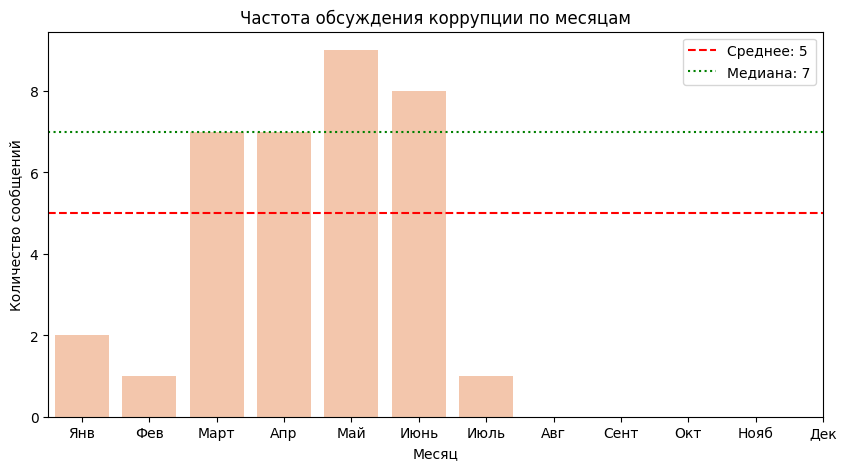

In [91]:
# Добавляем колонку с месяцами
df_corruption["month"] = df_corruption["date"].dt.month

# Группируем по месяцам
monthly_corruption = df_corruption.groupby("month")["id"].count().reset_index()

# Вычисляем среднее и медианное количество сообщений в месяц
mean_corruption = monthly_corruption["id"].mean()
median_corruption = monthly_corruption["id"].median()

# Вывод статистики
print(f" Среднее число сообщений о коррупции в месяц: {mean_corruption:.2f}")
print(f" Медианное число сообщений о коррупции в месяц: {median_corruption}")

# Строим график
plt.figure(figsize=(10, 5))
sns.barplot(data=monthly_corruption, x="month", y="id", color="#FFC3A0")

# Добавляем среднее и медиану на график
plt.axhline(mean_corruption, color='red', linestyle='dashed', label=f'Среднее: {mean_corruption:.0f}')
plt.axhline(median_corruption, color='green', linestyle='dotted', label=f'Медиана: {median_corruption:.0f}')

# Оформление графика
plt.xlabel("Месяц")
plt.ylabel("Количество сообщений")
plt.title("Частота обсуждения коррупции по месяцам")
plt.xticks(range(12), ['Янв', 'Фев', 'Март', 'Апр', 'Май', 'Июнь', 'Июль', 'Авг', 'Сент', 'Окт', 'Нояб', 'Дек'])
plt.legend()

plt.show()


### Дополнительная аналитика

Мы решили поискать в открытых данных Минкультуры что-то на тему студенчества и театров.

Скачаем датасет ["Театральные площадки и коллективы"](https://opendata.mkrf.ru/opendata/7705851331-theaters) и проведём небольшой анализ. Подключаться к API не будем, так как данные не такие объёмные.

Проанализируем описания театров на причастность к нашим самым популярным вузам: ГИТИСу, ВГИКу, РГИСИ

                                                   name  \
20                                    Театр «Квартет И»   
62             Студия театра, кино и телевидения «Зокх»   
86                Санкт-Петербургский Интерьерный театр   
118   Казанский татарский государственный театр юног...   
136            Театр «Переход» имени Геннадия Кириллова   
138                                     Городской театр   
167                                             Нетеатр   
188      Театр «Мастерская П. Н. Фоменко» (новая сцена)   
209               Драматический театр Балтийского флота   
240   Кабардинский государственный драматический теа...   
243       Государственный музыкальный театр г. Нальчика   
314         Калининградский областной музыкальный театр   
328   Московский театр музыки и драмы под руководств...   
345    Экспериментальный музыкально-драматический театр   
402   Русский государственный музыкально-драматическ...   
407                      Амурский областной театр кукол 

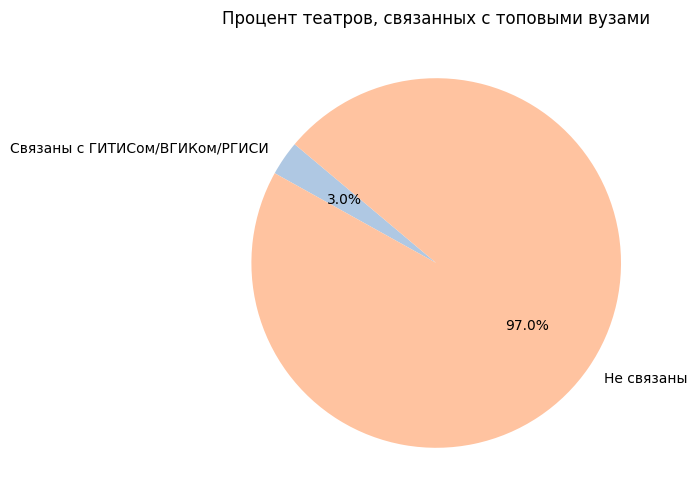

In [92]:
# Загружаем JSON
with open("data-95-structure-3.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Извлекаем названия и описания театров
theaters = []
for entry in data:
    theater_info = entry.get("data", {}).get("general", {})
    name = theater_info.get("name", "Без названия")
    description = theater_info.get("description", "")

    theaters.append({"name": name, "description": description})

# Преобразуем в DataFrame
df_theaters = pd.DataFrame(theaters)

# Ключевые слова для поиска
keywords = ["ГИТИС", "ГИТИСа", "ГИТИСе", "ГИТИСу", "ВГИК", "ВГИКе", "ВГИКу", "РГИСИ"]

# Фильтруем театры, в чьих описаниях есть эти слова
df_theaters_filtered = df_theaters[df_theaters["description"].str.contains("|".join(keywords), case=False, na=False)]

# Выводим найденные театры
print(df_theaters_filtered)

# Подсчитываем количество театров
num_theaters = len(df_theaters_filtered)

# Выводим количество театров
print(f"Количество театров, связанных с топовыми вузами: {num_theaters}")

# Строим круговую диаграмму
labels = ["Связаны с ГИТИСом/ВГИКом/РГИСИ", "Не связаны"]
sizes = [num_theaters, len(df_theaters) - num_theaters]
colors = ["#AFC8E3", "#FFC3A0"]

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", colors=colors, startangle=140)
plt.title("Процент театров, связанных с топовыми вузами")
plt.show()

Проанализируем студенческую и учебную направленность театров в общем, используем другие ключевые слова.

                                                   name  \
0                                   Театр «Комик-Трест»   
4                      Театральный центр «На Страстном»   
6                                   Площадка на Цветном   
9                                 Учебный театр «Дебют»   
10    Театр оперы и балета Санкт-Петербургской консе...   
...                                                 ...   
1037  Государственный национальный театр Удмуртской ...   
1039       Театр им. Евгения Вахтангова. Основная сцена   
1040   Московский Художественный театр им. А. П. Чехова   
1048  Саратовский государственный академический теат...   
1050                         Фольклорный центр «Москва»   

                                            description  
0     <p>Санкт-Петербургский театр «Комик-Трест» был...  
4     <p>Театральный центр СТД РФ «На Страстном» – у...  
6     <p><span>Площадка – это театральный камерный з...  
9     <p>Учебный театр «Дебют» – главная концертная ...  
1

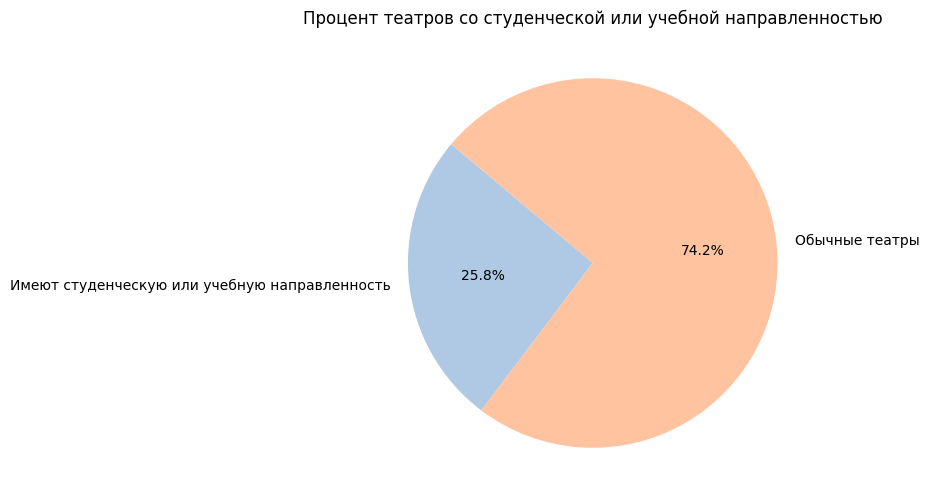

In [93]:
# Ключевые слова для поиска театров с учебной или студенческой направленностью
keywords_students = ["студенты", "лаборатория", "мастерская", "кастинг", "прослушивание", "курс", "учебный театр", "практика"]

# Фильтруем театры, в чьих описаниях есть эти слова
df_theaters_students_filtered = df_theaters[df_theaters["description"].str.contains("|".join(keywords_students), case=False, na=False)]

# Выводим найденные театры
print(df_theaters_students_filtered)

# Подсчитываем количество театров
num_theaters_students = len(df_theaters_students_filtered)

# Выводим количество театров
print(f"Количество театров, поддерживающих студентов: {num_theaters_students}")

# Строим круговую диаграмму
labels = ["Имеют студенческую или учебную направленность", "Обычные театры"]
sizes = [num_theaters_students, len(df_theaters) - num_theaters_students]
colors = ["#AFC8E3", "#FFC3A0"]

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", colors=colors, startangle=140)
plt.title("Процент театров со студенческой или учебной направленностью")
plt.show()

## Выводы


***Коротко по чатам в телеграме:***

1.   ГИТИС, РГИСИ и ВГИК – самые обсуждаемые вузы
2.   Главные темы – поступление, экзамены, сроки, эмоции абитуриентов
3.   Пик активности – перед экзаменами (май – июнь)
4.   Чаще всего обсуждают вечером, особенно по понедельникам и средам
5.   Коррупция упоминается в период поступления, но без явного перевеса по вузам
6.   Чат держится на небольшой группе активных пользователей

***Датасет Минкультуры:***

Немногие театры как-то включают в своё описание названия самых популярных театральных вузов (3%), но целая четверть театров из каталога каким-либо образом соотносится с учебными и студенческими активностями.